# Active learning in DeepSensor

DeepSensor allows you to perform active learning with your models to propose new context locations that are expected to improve the model's predictions.

This notebook demonstrates how to use DeepSensor's active learning algorithms to propose new context locations for a ConvNP model trained on ERA5 data.

## Set-up

In [2]:
# Load the "autoreload" extension so that code can change
%load_ext autoreload
# Always reload modules so that as you change code in src, it gets loaded
%autoreload 2

In [3]:
import deepsensor.torch as deepsensor
# import deepsensor.tensorflow as deepsensor
from deepsensor.data.processor import DataProcessor
from deepsensor.data.loader import TaskLoader
from deepsensor.model.convnp import ConvNP

In [4]:
from deepsensor.active_learning.algorithms import GreedyAlgorithm

from deepsensor.train.train import train_epoch, set_gpu_default_device
from deepsensor.data.utils import construct_x1x2_ds, construct_circ_time_ds

In [5]:
import numpy as np
import pandas as pd
import xarray as xr
import lab as B
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import seaborn as sns
sns.set_style("white")
from tqdm import tqdm

In [6]:
crs = ccrs.LambertAzimuthalEqualArea(0, -90)
test_date = pd.Timestamp("2014-01-01")

In [7]:
# Run on GPU if available by setting GPU as default device
set_gpu_default_device()

In [8]:
era5_raw_ds = xr.open_mfdataset('../../deepsensor_old/data/antarctica/gridded/interim/tas_anom/*.nc').sel(time=slice("1990-01-01", None))
era5_raw_ds

<xarray.Dataset>
Dimensions:    (time: 11323, y: 280, x: 280)
Coordinates:
  * time       (time) datetime64[ns] 1990-01-01 1990-01-02 ... 2020-12-31
  * y          (y) float64 3.488e+06 3.462e+06 ... -3.462e+06 -3.488e+06
  * x          (x) float64 -3.488e+06 -3.462e+06 ... 3.462e+06 3.488e+06
    dayofyear  (time) int64 dask.array<chunksize=(365,), meta=np.ndarray>
Data variables:
    t2m        (time, y, x) float32 dask.array<chunksize=(365, 280, 280), meta=np.ndarray>

In [9]:
aux_raw_ds = xr.open_mfdataset('../../deepsensor_old/data/antarctica/auxiliary/interim/*25000m/*.nc')
aux_raw_ds = aux_raw_ds[['surface', 'mask']]
aux_raw_ds

<xarray.Dataset>
Dimensions:  (y: 280, x: 280)
Coordinates:
  * y        (y) float64 3.488e+06 3.462e+06 3.438e+06 ... -3.462e+06 -3.488e+06
  * x        (x) float64 -3.488e+06 -3.462e+06 ... 3.462e+06 3.488e+06
    lat      (y, x) float32 dask.array<chunksize=(280, 280), meta=np.ndarray>
    lon      (y, x) float32 dask.array<chunksize=(280, 280), meta=np.ndarray>
Data variables:
    surface  (y, x) float32 dask.array<chunksize=(280, 280), meta=np.ndarray>
    mask     (y, x) float64 dask.array<chunksize=(280, 280), meta=np.ndarray>
Attributes: (12/19)
    Author:                      Mathieu Morlighem
    Data_citation:               Morlighem M. et al., (2019), Deep glacial tr...
    Notes:                       Data processed at the Department of Earth Sy...
    Projection:                  Polar Stereographic South (71S,0E)
    Title:                       BedMachine Antarctica
    ice_density (kg m-3):        917.0
    ...                          ...
    spacing:                     500
    valid_range:                 [0. 4.]
    version:                     15-Jul-2020 (v2.0)
    xmin:                        -3333000
    ymax:                        3333000
    Conventions:                 CF-1.7

In [10]:
data_processor = DataProcessor(
    x1_name='y', x1_map=(0, 3.5e6),
    x2_name='x', x2_map=(0, 3.5e6),
    verbose=True,
)
era5_ds = data_processor(era5_raw_ds, method="mean_std")
aux_ds = data_processor(aux_raw_ds, method="min_max")

Normalisation params for t2m not computed. Computing now... Done. t2m mean=0.314, std=3.883
Normalisation params for surface not computed. Computing now... Done. surface min=0.000, max=4047.722
Normalisation params for mask not computed. Computing now... Done. mask min=0.000, max=1.000


In [11]:
x1x2_ds = construct_x1x2_ds(aux_ds)
aux_ds['x1_arr'] = x1x2_ds['x1_arr']
aux_ds['x2_arr'] = x1x2_ds['x2_arr']

dates = pd.date_range(era5_ds.time.values.min(), era5_ds.time.values.max(), freq="D")
doy_ds = construct_circ_time_ds(dates, freq="D")
aux_ds["cos_D"] = doy_ds["cos_D"]
aux_ds["sin_D"] = doy_ds["sin_D"]

In [12]:
task_loader = TaskLoader(context=[era5_ds['t2m'], aux_ds], target=era5_ds['t2m'],
                         context_delta_t=0, target_delta_t=0,)
print(task_loader)

TaskLoader(2 context sets, 1 target sets)
Context variable IDs: (('t2m',), ('surface', 'mask', 'x1_arr', 'x2_arr', 'cos_D', 'sin_D'))
Target variable IDs: (('t2m',),)


In [13]:
model_dim = 30
model = ConvNP(data_processor, task_loader, unet_channels=(model_dim,) * 4, likelihood="cnp")

dim_yc inferred from TaskLoader: (1, 6)
dim_yt inferred from TaskLoader: 1
points_per_unit inferred from TaskLoader: 167
encoder_scales inferred from TaskLoader: [0.0035714285913854837, 0.0035714285913854837]


In [14]:
# Rather than training, we will load some pre-trained weights
load_weights = True
if load_weights:
    if deepsensor.backend.str == "tf":
        model.model.load_weights("../model.h5")
    elif deepsensor.backend.str == "torch":
        import torch
        model.model.load_state_dict(torch.load("../model.pt"))

## Active learning

First we will load some Antarctic station data that will be used to generate initial context set locations for our gridded ERA5 data

In [15]:
station_raw_df = pd.read_csv('../../deepsensor_old/data/antarctica/station/interim/XY_station.csv')
station_raw_df = station_raw_df.rename(columns={'date': 'time'})
station_raw_df['time'] = pd.to_datetime(station_raw_df['time'])
station_raw_df = station_raw_df.set_index(['time', 'y', 'x', 'station']).sort_index()[['tas']]

X_c_raw = station_raw_df.loc["2009-02-15"].reset_index()[["y", "x"]].values.T
X_c = data_processor.map_coord_array(X_c_raw)

In [16]:
task = task_loader(test_date, (X_c, "all"))

In [17]:
# xarray object containing a mask to remove ocean points from the search and target points
mask_ds = aux_raw_ds["mask"]

### Sequential greedy algorithm

Sequentially loop over all search points, passing a query observation to the model at that point and computing the change in acquisition function

In [18]:
greedy_alg = GreedyAlgorithm(
    model=model,
    X_t=era5_raw_ds,
    X_s=era5_raw_ds.coarsen(y=5, x=5, boundary="trim").mean(),  # Coarsen search points to speed up computation
    X_s_mask=mask_ds,  # Mask out ocean from search points
    X_t_mask=mask_ds,  # Mask out ocean from target points
    N_new_context=4,
)

Minimise the model's mean standard deviation - i.e. minimise the expected MAE under the model.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


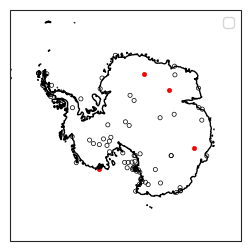

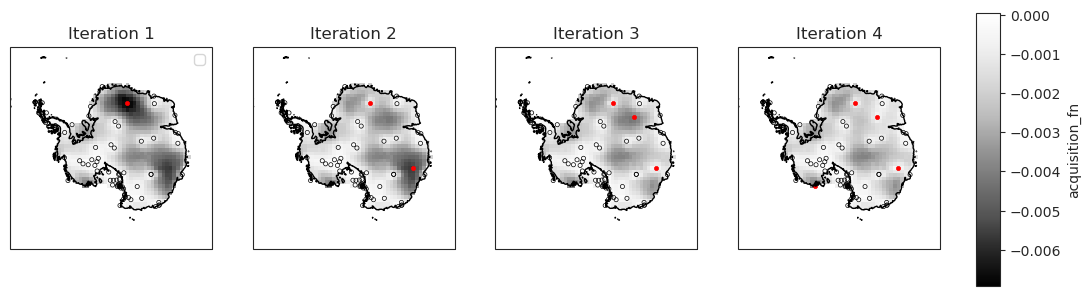

In [19]:
from deepsensor.active_learning.acquisition_fns import MeanStddev

acquisition_fn = MeanStddev(model)
X_new_df, acquisition_fn_ds = greedy_alg(acquisition_fn, task)

fig = deepsensor.plot.placements(task, X_new_df, data_processor, crs, extent=(-3.5e6, 3.5e6, -3.5e6, 3.5e6))
fig = deepsensor.plot.acquisition_fn(task, acquisition_fn_ds, X_new_df, data_processor, crs)

Computing the p-norm of the standard deviations can be used to place greater emphasis on reducing the largest standard deviations

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


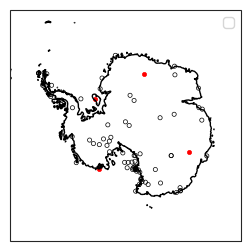

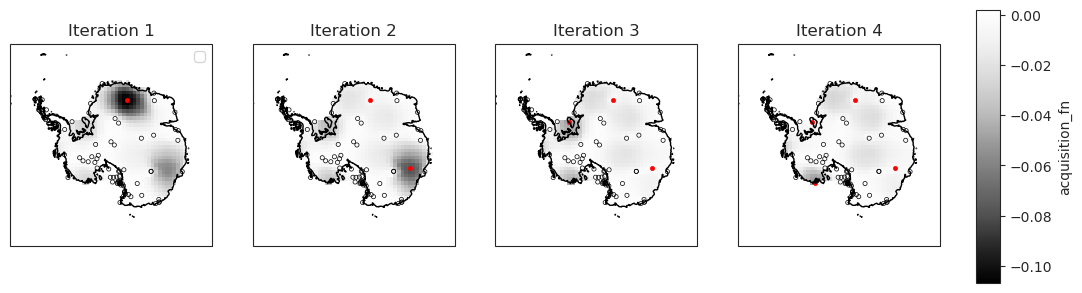

In [20]:
from deepsensor.active_learning.acquisition_fns import pNormStddev

acquisition_fn = pNormStddev(model, p=6)
X_new_df, acquisition_fn_ds = greedy_alg(acquisition_fn, task)

fig = deepsensor.plot.placements(task, X_new_df, data_processor, crs, extent=(-3.5e6, 3.5e6, -3.5e6, 3.5e6))
fig = deepsensor.plot.acquisition_fn(task, acquisition_fn_ds, X_new_df, data_processor, crs)

### Parallel greedy algorithm

Acquisition functions that inherit from `AcquisitionFunctionParallel` can be computed over all search points in parallel and are much faster, enabling finer search grids and more proposed context points.

In [21]:
greedy_alg = GreedyAlgorithm(
    model=model,
    X_t=era5_raw_ds,
    X_s=era5_raw_ds,
    X_s_mask=mask_ds,  # Mask out ocean from search points
    X_t_mask=mask_ds,  # Mask out ocean from target points
    N_new_context=50,
)

### Stddev

Use the model's standard deviation at search points as the acquisition function. Maximising this acquisition function will place context points at locations where the model is most uncertain.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


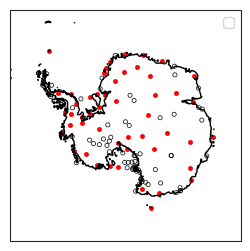

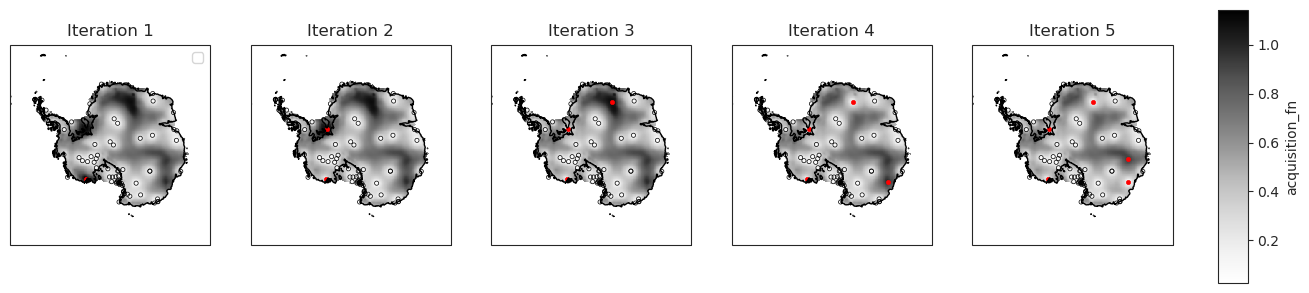

In [22]:
from deepsensor.active_learning.acquisition_fns import Stddev
dates = pd.date_range("2020-01-01", "2020-12-31", freq="1D")[::7]
tasks = task_loader(dates, (X_c, "all"))
acquisition_fn = Stddev(model)
X_new_df, acquisition_fn_ds = greedy_alg(acquisition_fn, tasks, "max")

fig = deepsensor.plot.placements(task, X_new_df, data_processor, crs, extent=(-3.5e6, 3.5e6, -3.5e6, 3.5e6))
fig = deepsensor.plot.acquisition_fn(task, acquisition_fn_ds.sel(iteration=slice(0, 4)), X_new_df, data_processor, crs, cmap="Greys")

### ExpectedImprovement

The Expected Improvement acquisition function can be used to hunt for the most positive or negative values in the data. In this case we will use the `ExpectedImprovement` acquisition function to search for the greatest temperature values over Antarctica. We will average the acquisition function over tasks sampled from 52 equally spaced dates in 2020 to make the acquisition function more robust to the weather on a single day.

In [23]:
from deepsensor.active_learning.acquisition_fns import ExpectedImprovement

dates = pd.date_range("2020-01-01", "2020-12-31", freq="1D")[::7]
tasks = task_loader(dates, (X_c, "all"))
tasks = task_loader(dates, (X_c, "all"))  # Try zero

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


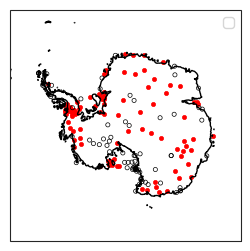

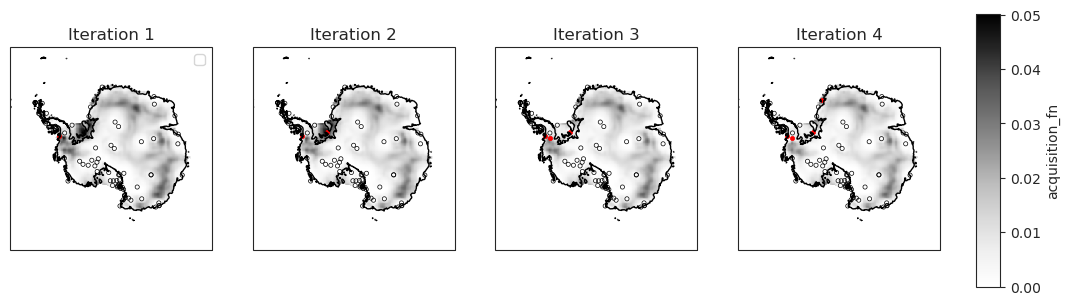

In [28]:
greedy_alg_with_groundtruth = GreedyAlgorithm(
    model=model,
    X_t=era5_raw_ds,
    X_s=era5_raw_ds,
    X_s_mask=mask_ds,  # Mask out ocean from search points
    X_t_mask=mask_ds,  # Mask out ocean from target points
    query_groundtruth=era5_ds,
    N_new_context=100,
)

acquisition_fn = ExpectedImprovement(model)
X_new_df, acquisition_fn_ds = greedy_alg_with_groundtruth(acquisition_fn, tasks, "max")
fig = deepsensor.plot.placements(tasks[0], X_new_df, data_processor, crs, extent=(-3.5e6, 3.5e6, -3.5e6, 3.5e6))
fig = deepsensor.plot.acquisition_fn(tasks[0], acquisition_fn_ds.sel(iteration=slice(0, 3)), X_new_df, data_processor, crs, cmap="Greys")

### ContextDist

Distance to the closest context point. Maximising this acquisition function will place context points at locations that are furthest from existing context points.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


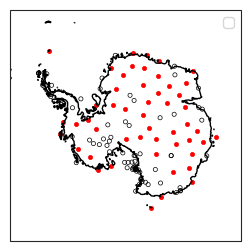

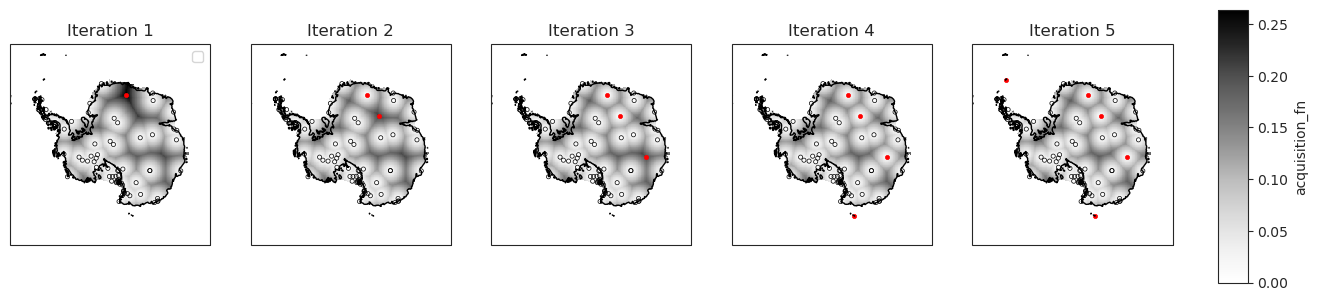

In [30]:
from deepsensor.active_learning.acquisition_fns import ContextDist

acquisition_fn = ContextDist(0)
X_new_df, acquisition_fn_ds = greedy_alg(acquisition_fn, task, "max")

fig = deepsensor.plot.placements(task, X_new_df, data_processor, crs, extent=(-3.5e6, 3.5e6, -3.5e6, 3.5e6))
fig = deepsensor.plot.acquisition_fn(task, acquisition_fn_ds.sel(iteration=slice(0, 4)), X_new_df, data_processor, crs, cmap="Greys")

### Random

Random acquisition function leading to placements - a useful baseline!

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


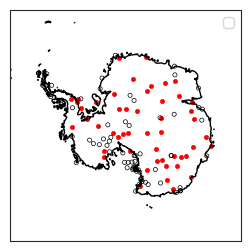

In [27]:
from deepsensor.active_learning.acquisition_fns import Random

acquisition_fn = Random()
X_new_df, acquisition_fn_ds = greedy_alg(acquisition_fn, task)

fig = deepsensor.plot.placements(task, X_new_df, data_processor, crs, extent=(-3.5e6, 3.5e6, -3.5e6, 3.5e6))